# Multi LoRA Image Generation

LoRA, or [Low-Rank Adaptation](https://arxiv.org/abs/2106.09685), is a popular and lightweight training technique used for fine-tuning Large Language and Stable Diffusion Models without needing full model training. Full fine-tuning of larger models (consisting of billions of parameters) is inherently expensive and time-consuming. LoRA works by adding a smaller number of new weights to the model for training, rather than retraining the entire parameter space of the model. This makes training with LoRA much faster, memory-efficient, and produces smaller model weights (a few hundred MBs), which are easier to store and share.

At its core, LoRA leverages the concept of low-rank matrix factorization. Instead of updating all the parameters in a neural network, LoRA decomposes the parameter space into two low-rank matrices. This decomposition allows the model to capture essential information with fewer parameters, significantly reducing the amount of data and computation required for fine-tuning.

![](https://github.com/user-attachments/assets/bf823c71-13b4-402c-a7b4-d6fc30a60d88)

By incorporating LoRA into Stable Diffusion models, we can enhance their ability to understand complex relationships and patterns in data.  This approach opens up numerous possibilities:
* **Art and Design**: Artists can fine-tune models to generate images that align with their unique styles, creating personalized artwork effortlessly.
* **Content Creation**: Businesses can customize image generation models to produce branded visuals, enhancing marketing and media production.
* **Entertainment**: Game developers and filmmakers can use fine-tuned models to create realistic and imaginative worlds, streamlining the creative process.
  
In this tutorial we explore possibilities to use LoRA with OpenVINO Generative API.

#### Table of contents:

- [Prerequisites](#Prerequisites)
- [Convert Diffusion Model using Optimum Intel](#Convert-Diffusion-Model-using-Optimum-Intel)
    - [Applying LoRA to Original Diffusers pipeline before conversion](#Applying-LoRA-to-Original-Diffusers-pipeline-before-conversion)
- [Image Generation using OpenVINO GenAI](#Image-Generation-using-OpenVINO-GenAI)
    - [Integration LoRA into pipeline](#Integration-LoRA-into-pipeline)
    - [Prepare LoRA Adapters](#Prepare-LoRA-Adapters)
    - [Create Inference Pipeline](#Create-Inference-Pipeline)
    - [Selection specific adapter during generation](#Selection-specific-adapter-during-generation)
    - [Use multiple adapters simultaneously](#Use-multiple-adapters-simultaneously)
    - [Disable adapters](#Disable-adapters)
- [Interactive demo](#Interactive-demo)


### Installation Instructions

This is a self-contained example that relies solely on its own code.

We recommend  running the notebook in a virtual environment. You only need a Jupyter server to start.
For details, please refer to [Installation Guide](https://github.com/openvinotoolkit/openvino_notebooks/blob/latest/README.md#-installation-guide).

<img referrerpolicy="no-referrer-when-downgrade" src="https://static.scarf.sh/a.png?x-pxid=5b5a4db0-7875-4bfb-bdbd-01698b5b1a77&file=notebooks/multilora-image-generation/multilora-image-generation.ipynb" />


In [ ]:
import platform

%pip install -q --extra-index-url https://download.pytorch.org/whl/cpu torch torchvision transformers accelerate "diffusers>0.25.0" pillow "gradio>=4.19" "peft>=0.7.0"
%pip install -q "git+https://github.com/huggingface/optimum-intel.git"
%pip install -q -U "openvino>=2024.5.0" "openvino-tokenizers>=2024.5.0" "openvino-genai>=2024.5.0"

if platform.system() == "Darwin":
    %pip install -q "numpy<2.0.0"

In [2]:
import requests
from pathlib import Path

notebook_utils_path = Path("notebook_utils.py")
lora_config_path = Path("lora_config.py")

if not notebook_utils_path.exists():
    r = requests.get(
        url="https://raw.githubusercontent.com/openvinotoolkit/openvino_notebooks/latest/utils/notebook_utils.py",
    )
    notebook_utils_path.open("w").write(r.text)

if not lora_config_path.exists():
    r = requests.get(
        url="https://raw.githubusercontent.com/openvinotoolkit/openvino_notebooks/latest/notebooks/multilora-image-generation/lora_config.py",
    )
    lora_config_path.open("w").write(r.text)

## Convert Diffusion Model using Optimum Intel
[back to top ⬆️](#Table-of-contents:)


🤗 [Optimum Intel](https://huggingface.co/docs/optimum/intel/index) is the interface between the 🤗 [Transformers](https://huggingface.co/docs/transformers/index) and [Diffusers](https://huggingface.co/docs/diffusers/index) libraries and OpenVINO to accelerate end-to-end pipelines on Intel architectures. It provides ease-to-use [interface](https://huggingface.co/docs/optimum/intel/openvino/export) for exporting models to [OpenVINO Intermediate Representation (IR)](https://docs.openvino.ai/2024/documentation/openvino-ir-format.html) format.

### Applying LoRA to Original Diffusers pipeline before conversion
[back to top ⬆️](#Table-of-contents:)


LoRA can be easily added to [Diffusers pipeline](https://huggingface.co/docs/diffusers/main/en/using-diffusers/loading_adapters#lora) before export. At the export stage, LoRA weights will be fused to original model weights and converted model will preserve LoRA provided behavior. This approach is suitable when you need model with adapter capabilities by default and it does not required configuration at inference time (e.g. changing weight coefficient for adapter).
For example, we can use this method for speedup generation process with integration [LCM LoRA](https://huggingface.co/blog/lcm_lora). Previously, we already considered with approach in this [tutorial](../latent-consistency-models-image-generation/lcm-lora-controlnet.ipynb).

Using `optimum-cli` for exporting models requires to provide model id on HuggingFace Hub or local directory with saved model. In case, if model stored in multiple separated repositories or directories (e.g. you want to replace VAE component or add LoRA), it should be merged and saved on disk before export. For avoiding this, we will use `export_from_model` function that accepts initialized model. Additionally, for using model with OpenVINO GenAI, we need to export tokenizers to OpenVINO format using [OpenVINO Tokenizers](https://docs.openvino.ai/2024/learn-openvino/llm_inference_guide/ov-tokenizers.html) library.

In this tutorial we will use [Stable Diffusion XL](https://huggingface.co/stabilityai/stable-diffusion-xl-base-1.0) model, but the same steps are also applicable to other models of Stable Diffusion family.

In [3]:
from pathlib import Path
from diffusers import DiffusionPipeline, AutoencoderKL, LCMScheduler
from optimum.exporters.openvino import export_from_model
from optimum.intel.openvino import OVConfig
from optimum.exporters.openvino.convert import export_tokenizer
import gc

model_dir = Path("sdxl-lcm")

if not model_dir.exists():
    model_id = "stabilityai/stable-diffusion-xl-base-1.0"
    adapter_id = "latent-consistency/lcm-lora-sdxl"
    vae_id = "madebyollin/sdxl-vae-fp16-fix"
    vae = AutoencoderKL.from_pretrained("madebyollin/sdxl-vae-fp16-fix")
    pipe = DiffusionPipeline.from_pretrained(model_id, vae=vae, variant="fp16", use_safetensors=True)
    pipe.scheduler = LCMScheduler.from_config(pipe.scheduler.config)
    pipe.load_lora_weights(adapter_id)
    pipe.fuse_lora()
    export_from_model(pipe, model_dir, task="text-to-image", stateful=False, ov_config=OVConfig(dtype="fp16"))
    for tokenizer in ["tokenizer", "tokenizer_2"]:
        tokenizer_model = getattr(pipe, tokenizer, None)
        if tokenizer_model is not None:
            export_tokenizer(tokenizer_model, model_dir / tokenizer, task="text-to-image")
    del vae
    del pipe
    gc.collect()

2024-11-08 16:49:48.963221: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-08 16:49:48.977712: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1731070188.992824  718925 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1731070188.997386  718925 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-08 16:49:49.014687: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

## Image Generation using OpenVINO GenAI
[back to top ⬆️](#Table-of-contents:)


[OpenVINO™ GenAI](https://github.com/openvinotoolkit/openvino.genai) is a library of the most popular Generative AI model pipelines, optimized execution methods, and samples that run on top of highly performant [OpenVINO Runtime](https://github.com/openvinotoolkit/openvino).

This library is friendly to PC and laptop execution, and optimized for resource consumption. It requires no external dependencies to run generative models as it already includes all the core functionality.

`openvino_genai.Text2ImagePipeline` class supports inference of [Diffusers models](https://github.com/openvinotoolkit/openvino.genai/blob/master/src/docs/SUPPORTED_MODELS.md#text-2-image-models). For pipeline initialization, we should provide directory with converted by Optimum Intel pipeline and specify inference device. Optionally, we can provide configuration for LoRA Adapters using `adapter_config`. For starting generation process `generate` method should be used. Basically, it required to provide input text prompt for image generation. You can provide additional arguments like negative prompt, number of steps, guidance scale, image width and height to control generation process.

### Integration LoRA into pipeline
[back to top ⬆️](#Table-of-contents:)


Similarly to Diffusers pipeline, you can store separately and load LoRA into base pipeline before inference using OpenVINO GenAI.
`openvino_genai.AdapterConfig` serves for adapters management in `openvino_genai.Text2ImagePipeline`. It can be used for adding and removing adapters or changing their weight coefficient for blending into pipeline. You can add one or multiple adapters into config and also specify alpha blending coefficients for their addition. OpenVINO GenAI supports LoRA adapters saved in Safetensors format. You can use one of publicly available pretrained adapters from [CivitAI](https://civitai.com/) or [HuggingFace Hub](https://huggingface.co/models) or train your own.
> **Important Note**: Before loading pretrained adapters, please make sure that they are compatible with your base model architecture. E.g. if you use SDXL model, you need to provide adapters trained for this model type and loading adapter, for example, trained for FLUX is not allowed.

Generally, process of adapters configuration consists of 2 steps:
1. Register adapters in pipeline constructor. At this moment, it is recommended to provide all adapters that you plan to use on this stage.
2. Choose which adapter (or a combination of adapters) to apply in each `generate` call. It is not obligated to use all of provided in constructor adapters simultaneously, you can select one or combination of several among them for each generation cycle.


### Prepare LoRA Adapters
[back to top ⬆️](#Table-of-contents:)

### Prepare LoRA Adapters

In [4]:
from lora_config import LORA

# uncomment this line to see predefined LoRA adapters configuration used in this notebook
# LORA

In [5]:
from huggingface_hub import hf_hub_download

lora_dir = Path("lora")
adapter_paths = []

for lora in LORA:
    lora_model_dir = lora_dir / lora["name"].lower().replace(" ", "_")
    file_name = lora["file_name"]
    if not (lora_model_dir / file_name).exists():
        hf_hub_download(repo_id=lora["model_id"], filename=file_name, local_dir=lora_model_dir)
    adapter_paths.append(lora_model_dir / file_name)

In [6]:
import openvino_genai as ov_genai


def prepare_adapter_config(scales=None):
    if scales is None:
        scales = [1 / len(adapter_paths)] * len(adapter_paths)
    if isinstance(scales, float):
        scales = [scales] * len(adapter_paths)
    adapter_config = ov_genai.AdapterConfig()
    for adapter, scale in zip(adapter_paths, scales):
        adapter_config.add(ov_genai.Adapter(adapter), scale)

    return adapter_config


adapters_config = prepare_adapter_config(0.0)
adapters = adapters_config.get_adapters()

### Create Inference Pipeline
[back to top ⬆️](#Table-of-contents:)


diffusion process involves random for preparing initial state for denoising. For reproducibility of generation results, we will use `Generator` class. 

In [7]:
from notebook_utils import device_widget

device = device_widget(default="CPU", exclude=["NPU"])
device

Dropdown(description='Device:', options=('CPU', 'AUTO'), value='CPU')

In [8]:
import openvino as ov
import torch


class Generator(ov_genai.Generator):
    def __init__(self, seed):
        ov_genai.Generator.__init__(self)
        self.generator = torch.Generator(device="cpu").manual_seed(seed)

    def next(self):
        return torch.randn(1, generator=self.generator, dtype=torch.float32).item()

    def randn_tensor(self, shape: ov.Shape):
        torch_tensor = torch.randn(list(shape), generator=self.generator, dtype=torch.float32)
        return ov.Tensor(torch_tensor.numpy())


pipe = ov_genai.Text2ImagePipeline(model_dir, "CPU", adapters=adapters_config)

### Selection specific adapter during generation
[back to top ⬆️](#Table-of-contents:)


As it was already mention before, it is not necessary to use all adapters specified at initialization stage for generation in the same time. Providing adapters argument with `openvino_genai.AdapterConfig`  into `generate` allow to select one or several from them. For example, let's select LoRA for generation images in X-Ray style.

In [9]:
subject = "a cute cat in sunglasses"
prompt_template = LORA[0].get("prompt", "<subject>")
adapter_weight = LORA[0].get("weight", 1.0)
prompt = prompt_template.replace("<subject>", subject)
adapter_config = ov_genai.AdapterConfig()
adapter_config.add(adapters[0], adapter_weight)
image_tensor = pipe.generate(prompt, num_inference_steps=4, guidance_scale=0, adapters=adapter_config, generator=Generator(421235))

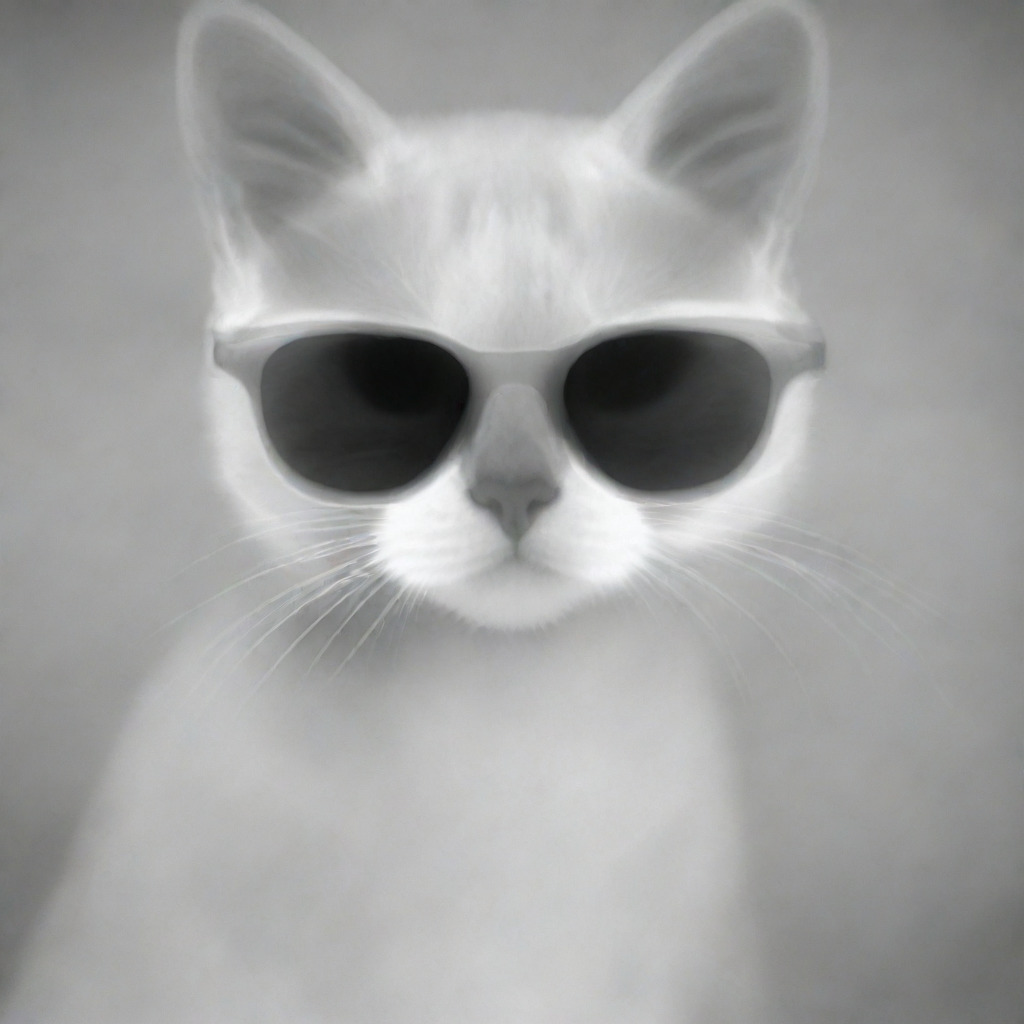

In [10]:
from PIL import Image

image = Image.fromarray(image_tensor.data[0])
image

### Use multiple adapters simultaneously
[back to top ⬆️](#Table-of-contents:)


You also can use combination of adapters that will be applied in the same time. Let's see what happens if traditional Japanese art will meet modern illustration pointillistic style.

In [11]:
prompt_template1 = LORA[1].get("prompt", "<subject>")
prompt_template2 = LORA[2].get("prompt", "<subject>")
adapter1_weight = LORA[1].get("weight", 1.0)
adapter2_weight = LORA[2].get("weight", 1.0)

prompt = prompt_template2.replace("<subject>", prompt_template1.replace("<subject>", subject))
adapter_config = ov_genai.AdapterConfig()
adapter_config.add(adapters[1], adapter1_weight)
adapter_config.add(adapters[2], adapter2_weight)
image_tensor = pipe.generate(prompt, num_inference_steps=4, guidance_scale=0, adapters=adapter_config, generator=Generator(421235))

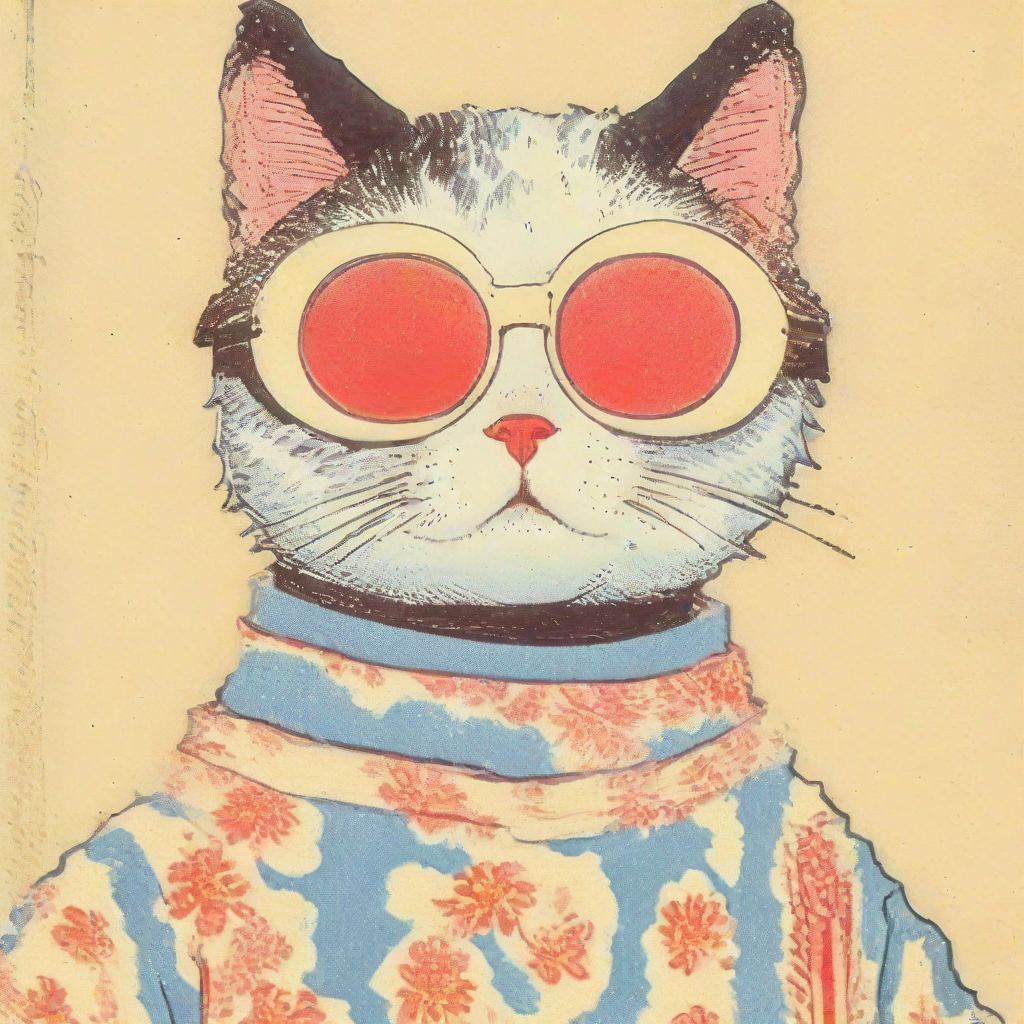

In [12]:
image = Image.fromarray(image_tensor.data[0])
image

### Disable adapters
[back to top ⬆️](#Table-of-contents:)


You can disable adapters providing empty `AdapterConfig` into generate

In [13]:
image_tensor = pipe.generate(subject, num_inference_steps=4, guidance_scale=0, adapters=ov_genai.AdapterConfig(), generator=Generator(421235))

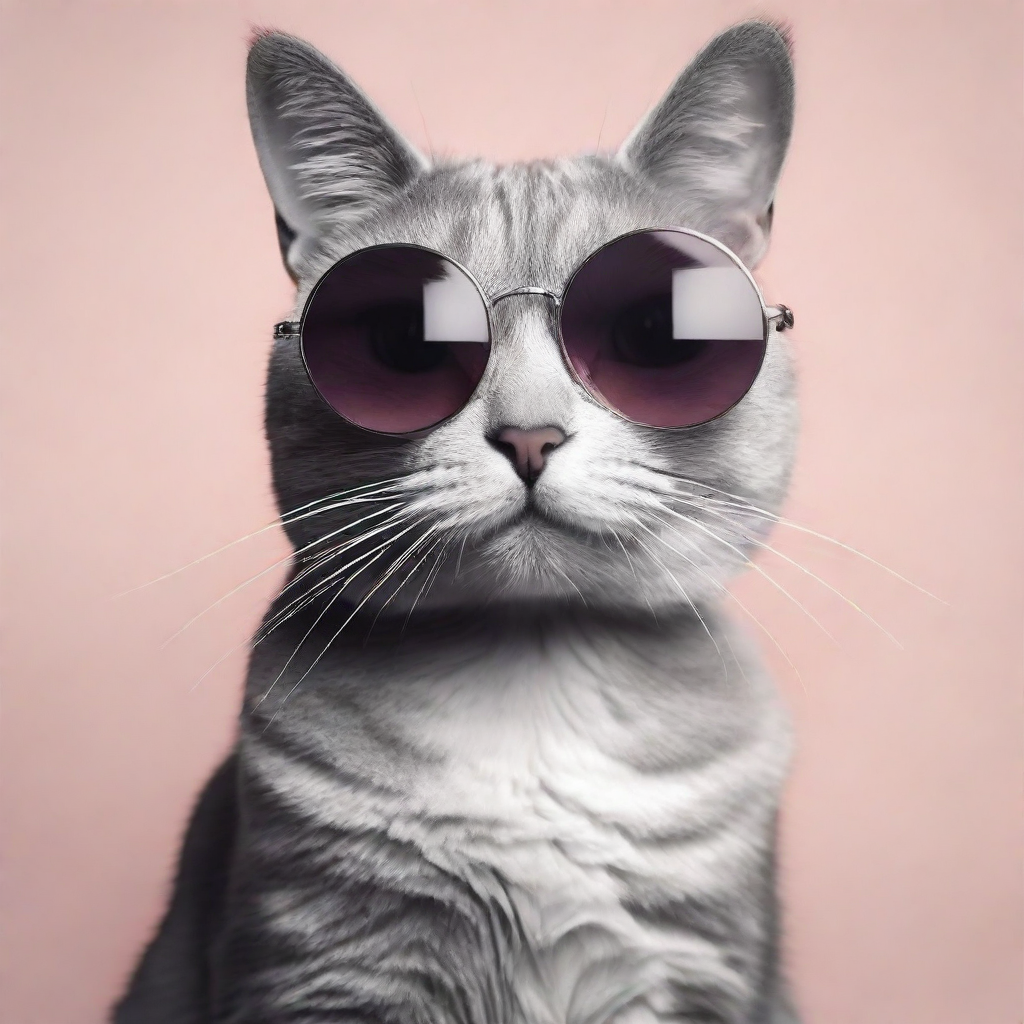

In [14]:
image = Image.fromarray(image_tensor.data[0])
image

## Interactive demo
[back to top ⬆️](#Table-of-contents:)

In [ ]:
gradio_helper_path = Path("gradio_helper.py")

if not gradio_helper_path.exists():
    r = requests.get(
        url="https://raw.githubusercontent.com/openvinotoolkit/openvino_notebooks/latest/notebooks/multilora-image-generation/gradio_helper.py",
    )
    lora_config_path.open("w").write(r.text)

In [ ]:
from gradio_helper import make_demo

demo = make_demo(pipe, Generator, adapters, LORA)

try:
    demo.launch(debug=True)
except Exception:
    demo.launch(share=True, debug=True)
# if you are launching remotely, specify server_name and server_port
# demo.launch(server_name='your server name', server_port='server port in int')
# Read more in the docs: https://gradio.app/docs/